In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, 
import os

In [2]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [3]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# Data Visualization
import plotly.express as px

In [5]:
import sys
from tqdm import tqdm
import time
import copy

In [6]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [7]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            #T.RandomHorizontalFlip(),
            #T.RandomVerticalFlip(),
            #T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.20),
            #T.RandomRotation(degrees=(-45, 45)),
            #T.RandomResizedCrop(size=(384, 384), scale=(0.8, 1.0), ratio=(0.75, 1.3333)),
            #T.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10)),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet means and standard deviations
    # T.RandomErasing(p=0.2, value='random')  # You can uncomment this line if needed
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [8]:
dataset_path = "/kaggle/input/all-dataset2-splitted/ALL_Splitted/train/"

In [9]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 32, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [10]:
classes = get_classes("/kaggle/input/all-dataset2-splitted/ALL_Splitted/train/")

In [11]:
# Get Class Names
class_names = sorted(os.listdir(dataset_path))
n_classes = len(class_names)

# Show
print(f"Class Names : {class_names}")
print(f"Number of Classes  : {n_classes}")

Class Names : ['Benign', 'Early', 'Pre', 'Pro']
Number of Classes  : 4


In [13]:
# Calculate class distribution
class_dis = [len(os.listdir(dataset_path + name)) for name in class_names]
class_dis

[302, 591, 577, 482]

In [14]:
# Visualization
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [16]:
pred_dataset_path = "/kaggle/input/all-dataset2-splitted/ALL_Splitted/test/"
# Calculate class distribution
class_dis = [len(os.listdir(pred_dataset_path + name)) for name in class_names]

# Visualization
fig = px.pie(names=class_names, values=class_dis, title="Prediction Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [17]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [18]:
print(len(train_loader), len(val_loader), len(test_loader))

61 21 21


In [19]:
print(train_data_len, valid_data_len, test_data_len)

1952 649 655


In [20]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [48]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm

#timm.list_models('**')

model = timm.create_model('resnet152', pretrained=True)

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

In [49]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [50]:
import torch.nn as nn

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): Linear(in_features=512, out_features=4, bias=True)
)


In [51]:
criterion =  nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [52]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import time
import copy
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
!pip install seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

import time
import copy
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, criterion, optimizer, scheduler, num_epochs=100, patience=500):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    no_improvement_count = 0

    val_true_labels = []
    val_pred_labels = []
    val_pred_probs = []
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'val':
                    val_true_labels += labels.tolist()
                    val_pred_labels += preds.tolist()
                    val_pred_probs += torch.softmax(outputs, dim=1).tolist()

            if phase == 'train':
                train_loss_history.append(running_loss / dataset_sizes[phase])
            else:
                val_loss_history.append(running_loss / dataset_sizes[phase])

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, running_loss / dataset_sizes[phase], epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
                no_improvement_count = 0
            elif phase == 'val':
                no_improvement_count += 1

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

        print()

        if no_improvement_count >= patience:
            print(f"No improvement in validation accuracy for {no_improvement_count} epochs. Early stopping...")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)


    # Calculate confusion matrix, F1 score, sensitivity, specificity, accuracy, and Cohen's kappa
    confusion_mat = confusion_matrix(val_true_labels, val_pred_labels)
    f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')
    sensitivity = confusion_mat.diagonal() / confusion_mat.sum(axis=1)
    specificity = np.diag(confusion_mat) / np.sum(confusion_mat, axis=1)
    accuracy = np.sum(np.diag(confusion_mat)) / np.sum(confusion_mat)
    true_positives = np.diag(confusion_mat)
    true_negatives = np.sum(confusion_mat) - (np.sum(true_positives) + np.sum(confusion_mat.sum(axis=0)) - np.sum(true_positives))
    false_positives = confusion_mat.sum(axis=0) - true_positives
    false_negatives = confusion_mat.sum(axis=1) - true_positives
    kappa = cohen_kappa_score(val_true_labels, val_pred_labels)

    # Print confusion matrix, F1 score, sensitivity, specificity, accuracy, and Cohen's kappa
    print("Confusion Matrix:")
    print(confusion_mat)
    print("F1 Score: {:.4f}".format(f1))
    print("Sensitivity (Recall):", sensitivity)
    print("Specificity:", specificity)
    print("Accuracy: {:.4f}".format(accuracy))
    print("True Positives:", true_positives)
    print("True Negatives:", true_negatives)
    print("False Positives:", false_positives)
    print("False Negatives:", false_negatives)
    print("Cohen's Kappa:", kappa)


    # Print classification report
    target_names = [str(i) for i in range(len(classes))]
    print(classification_report(val_true_labels, val_pred_labels, target_names=target_names))
    
    
    
    # Set Seaborn style
    sns.set(style="darkgrid")
    # Plot accuracy curves
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(train_acc_history) + 1), y=train_acc_history, label='Train', linestyle='-', color='#2C5D63')
    sns.lineplot(x=range(1, len(val_acc_history) + 1), y=val_acc_history, label='Validation', linestyle='-', color='#6C5F5B')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(train_loss_history) + 1), y=train_loss_history, label='Train', linestyle='-', color='#2C5D63')
    sns.lineplot(x=range(1, len(val_loss_history) + 1), y=val_loss_history, label='Validation', linestyle='-', color='#6C5F5B')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    confusion_mat = confusion_matrix(val_true_labels, val_pred_labels, labels=np.arange(len(classes)))
    # Plot customized confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_mat, annot=True, fmt=".0f", cmap="YlGn", linewidths=.5, square=True, cbar=False,
                xticklabels=classes, yticklabels=classes)
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, ha='right')
    
    plt.tight_layout()
    plt.show()

Epoch 0/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


train Loss: 0.1144 Acc: 0.9641


100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


val Loss: 0.0938 Acc: 0.9738

Epoch 1/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.17it/s]


train Loss: 0.0917 Acc: 0.9672


100%|██████████| 21/21 [00:03<00:00,  6.76it/s]


val Loss: 0.0869 Acc: 0.9676

Epoch 2/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.17it/s]


train Loss: 0.0715 Acc: 0.9764


100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


val Loss: 0.1170 Acc: 0.9599

Epoch 3/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.18it/s]


train Loss: 0.0650 Acc: 0.9795


100%|██████████| 21/21 [00:03<00:00,  6.93it/s]


val Loss: 0.0811 Acc: 0.9723

Epoch 4/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


train Loss: 0.0484 Acc: 0.9831


100%|██████████| 21/21 [00:03<00:00,  6.89it/s]


val Loss: 0.0804 Acc: 0.9738

Epoch 5/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


train Loss: 0.0695 Acc: 0.9754


100%|██████████| 21/21 [00:03<00:00,  6.93it/s]


val Loss: 0.0642 Acc: 0.9800

Epoch 6/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.17it/s]


train Loss: 0.0411 Acc: 0.9831


100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


val Loss: 0.0755 Acc: 0.9753

Epoch 7/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.19it/s]


train Loss: 0.0366 Acc: 0.9872


100%|██████████| 21/21 [00:03<00:00,  6.85it/s]


val Loss: 0.1187 Acc: 0.9553

Epoch 8/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0388 Acc: 0.9872


100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


val Loss: 0.0778 Acc: 0.9769

Epoch 9/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0317 Acc: 0.9887


100%|██████████| 21/21 [00:03<00:00,  6.90it/s]


val Loss: 0.1081 Acc: 0.9692

Epoch 10/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0612 Acc: 0.9764


100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


val Loss: 0.1824 Acc: 0.9414

Epoch 11/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.23it/s]


train Loss: 0.0735 Acc: 0.9759


100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


val Loss: 0.1403 Acc: 0.9569

Epoch 12/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0544 Acc: 0.9826


100%|██████████| 21/21 [00:03<00:00,  6.90it/s]


val Loss: 0.0909 Acc: 0.9707

Epoch 13/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0254 Acc: 0.9918


100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


val Loss: 0.1373 Acc: 0.9553

Epoch 14/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0315 Acc: 0.9903


100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


val Loss: 0.0855 Acc: 0.9738

Epoch 15/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


train Loss: 0.0170 Acc: 0.9923


100%|██████████| 21/21 [00:03<00:00,  6.99it/s]


val Loss: 0.0798 Acc: 0.9738

Epoch 16/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.19it/s]


train Loss: 0.0341 Acc: 0.9887


100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


val Loss: 0.1241 Acc: 0.9661

Epoch 17/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.18it/s]


train Loss: 0.0558 Acc: 0.9821


100%|██████████| 21/21 [00:03<00:00,  6.83it/s]


val Loss: 0.0879 Acc: 0.9692

Epoch 18/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0290 Acc: 0.9892


100%|██████████| 21/21 [00:03<00:00,  6.86it/s]


val Loss: 0.0889 Acc: 0.9707

Epoch 19/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0250 Acc: 0.9913


100%|██████████| 21/21 [00:03<00:00,  6.87it/s]


val Loss: 0.1039 Acc: 0.9630

Epoch 20/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.24it/s]


train Loss: 0.0317 Acc: 0.9887


100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


val Loss: 0.1083 Acc: 0.9661

Epoch 21/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0184 Acc: 0.9933


100%|██████████| 21/21 [00:03<00:00,  6.93it/s]


val Loss: 0.1288 Acc: 0.9723

Epoch 22/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.17it/s]


train Loss: 0.0312 Acc: 0.9903


100%|██████████| 21/21 [00:02<00:00,  7.01it/s]


val Loss: 0.0885 Acc: 0.9692

Epoch 23/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.19it/s]


train Loss: 0.0215 Acc: 0.9923


100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


val Loss: 0.1051 Acc: 0.9661

Epoch 24/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0257 Acc: 0.9892


100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


val Loss: 0.2119 Acc: 0.9368

Epoch 25/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0303 Acc: 0.9872


100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


val Loss: 0.1150 Acc: 0.9769

Epoch 26/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0185 Acc: 0.9928


100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


val Loss: 0.0713 Acc: 0.9815

Epoch 27/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.14it/s]


train Loss: 0.0253 Acc: 0.9913


100%|██████████| 21/21 [00:03<00:00,  6.92it/s]


val Loss: 0.2664 Acc: 0.9307

Epoch 28/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


train Loss: 0.0286 Acc: 0.9882


100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


val Loss: 0.1089 Acc: 0.9599

Epoch 29/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.23it/s]


train Loss: 0.0177 Acc: 0.9949


100%|██████████| 21/21 [00:03<00:00,  6.92it/s]


val Loss: 0.1028 Acc: 0.9723

Epoch 30/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0174 Acc: 0.9933


100%|██████████| 21/21 [00:03<00:00,  6.93it/s]


val Loss: 0.1889 Acc: 0.9522

Epoch 31/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0190 Acc: 0.9933


100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


val Loss: 0.0885 Acc: 0.9769

Epoch 32/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0137 Acc: 0.9944


100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


val Loss: 0.1077 Acc: 0.9707

Epoch 33/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0219 Acc: 0.9928


100%|██████████| 21/21 [00:03<00:00,  6.88it/s]


val Loss: 0.0837 Acc: 0.9723

Epoch 34/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.23it/s]


train Loss: 0.0393 Acc: 0.9862


100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


val Loss: 0.0855 Acc: 0.9707

Epoch 35/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.18it/s]


train Loss: 0.0160 Acc: 0.9933


100%|██████████| 21/21 [00:03<00:00,  6.93it/s]


val Loss: 0.0637 Acc: 0.9769

Epoch 36/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0507 Acc: 0.9831


100%|██████████| 21/21 [00:03<00:00,  6.93it/s]


val Loss: 0.1692 Acc: 0.9599

Epoch 37/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0404 Acc: 0.9887


100%|██████████| 21/21 [00:03<00:00,  6.95it/s]


val Loss: 0.0707 Acc: 0.9723

Epoch 38/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


train Loss: 0.0477 Acc: 0.9816


100%|██████████| 21/21 [00:03<00:00,  6.22it/s]


val Loss: 0.0572 Acc: 0.9769

Epoch 39/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0250 Acc: 0.9908


100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


val Loss: 0.1111 Acc: 0.9738

Epoch 40/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0409 Acc: 0.9877


100%|██████████| 21/21 [00:03<00:00,  6.90it/s]


val Loss: 0.0758 Acc: 0.9738

Epoch 41/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0128 Acc: 0.9959


100%|██████████| 21/21 [00:03<00:00,  6.92it/s]


val Loss: 0.1224 Acc: 0.9630

Epoch 42/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.19it/s]


train Loss: 0.0120 Acc: 0.9949


100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


val Loss: 0.0690 Acc: 0.9769

Epoch 43/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0178 Acc: 0.9933


100%|██████████| 21/21 [00:03<00:00,  6.95it/s]


val Loss: 0.1308 Acc: 0.9615

Epoch 44/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0574 Acc: 0.9810


100%|██████████| 21/21 [00:03<00:00,  6.92it/s]


val Loss: 0.0782 Acc: 0.9738

Epoch 45/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0309 Acc: 0.9892


100%|██████████| 21/21 [00:03<00:00,  6.84it/s]


val Loss: 0.0866 Acc: 0.9784

Epoch 46/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.15it/s]


train Loss: 0.0148 Acc: 0.9928


100%|██████████| 21/21 [00:03<00:00,  6.87it/s]


val Loss: 0.0913 Acc: 0.9707

Epoch 47/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.14it/s]


train Loss: 0.0191 Acc: 0.9939


100%|██████████| 21/21 [00:03<00:00,  6.76it/s]


val Loss: 0.1487 Acc: 0.9661

Epoch 48/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.17it/s]


train Loss: 0.0195 Acc: 0.9944


100%|██████████| 21/21 [00:03<00:00,  6.90it/s]


val Loss: 0.2160 Acc: 0.9538

Epoch 49/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.10it/s]


train Loss: 0.0725 Acc: 0.9780


100%|██████████| 21/21 [00:03<00:00,  6.76it/s]


val Loss: 0.3222 Acc: 0.9183

Epoch 50/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


train Loss: 0.0430 Acc: 0.9841


100%|██████████| 21/21 [00:03<00:00,  6.78it/s]


val Loss: 0.0729 Acc: 0.9738

Epoch 51/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.15it/s]


train Loss: 0.0135 Acc: 0.9959


100%|██████████| 21/21 [00:03<00:00,  6.80it/s]


val Loss: 0.0799 Acc: 0.9707

Epoch 52/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.18it/s]


train Loss: 0.0156 Acc: 0.9959


100%|██████████| 21/21 [00:03<00:00,  6.85it/s]


val Loss: 0.0762 Acc: 0.9707

Epoch 53/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.18it/s]


train Loss: 0.0337 Acc: 0.9892


100%|██████████| 21/21 [00:03<00:00,  6.82it/s]


val Loss: 0.0884 Acc: 0.9738

Epoch 54/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.13it/s]


train Loss: 0.0255 Acc: 0.9939


100%|██████████| 21/21 [00:03<00:00,  6.86it/s]


val Loss: 0.0849 Acc: 0.9707

Epoch 55/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.18it/s]


train Loss: 0.0231 Acc: 0.9898


100%|██████████| 21/21 [00:03<00:00,  6.83it/s]


val Loss: 0.0669 Acc: 0.9784

Epoch 56/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.18it/s]


train Loss: 0.0162 Acc: 0.9949


100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


val Loss: 0.0974 Acc: 0.9753

Epoch 57/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.17it/s]


train Loss: 0.0168 Acc: 0.9944


100%|██████████| 21/21 [00:03<00:00,  6.84it/s]


val Loss: 0.0656 Acc: 0.9800

Epoch 58/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0094 Acc: 0.9959


100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


val Loss: 0.0932 Acc: 0.9769

Epoch 59/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0197 Acc: 0.9964


100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


val Loss: 0.0652 Acc: 0.9784

Epoch 60/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


train Loss: 0.0167 Acc: 0.9944


100%|██████████| 21/21 [00:03<00:00,  6.95it/s]


val Loss: 0.0887 Acc: 0.9753

Epoch 61/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0179 Acc: 0.9939


100%|██████████| 21/21 [00:03<00:00,  6.91it/s]


val Loss: 0.1326 Acc: 0.9676

Epoch 62/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.19it/s]


train Loss: 0.0159 Acc: 0.9959


100%|██████████| 21/21 [00:03<00:00,  6.87it/s]


val Loss: 0.0720 Acc: 0.9815

Epoch 63/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0224 Acc: 0.9913


100%|██████████| 21/21 [00:03<00:00,  6.85it/s]


val Loss: 0.0720 Acc: 0.9738

Epoch 64/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0319 Acc: 0.9913


100%|██████████| 21/21 [00:03<00:00,  6.82it/s]


val Loss: 0.0807 Acc: 0.9769

Epoch 65/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.17it/s]


train Loss: 0.0129 Acc: 0.9954


100%|██████████| 21/21 [00:03<00:00,  6.91it/s]


val Loss: 0.0674 Acc: 0.9800

Epoch 66/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.19it/s]


train Loss: 0.0085 Acc: 0.9969


100%|██████████| 21/21 [00:03<00:00,  6.90it/s]


val Loss: 0.0851 Acc: 0.9738

Epoch 67/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0436 Acc: 0.9867


100%|██████████| 21/21 [00:03<00:00,  6.99it/s]


val Loss: 0.1066 Acc: 0.9707

Epoch 68/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.17it/s]


train Loss: 0.0091 Acc: 0.9980


100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


val Loss: 0.0679 Acc: 0.9784

Epoch 69/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


train Loss: 0.0114 Acc: 0.9954


100%|██████████| 21/21 [00:03<00:00,  6.91it/s]


val Loss: 0.0681 Acc: 0.9846

Epoch 70/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0268 Acc: 0.9898


100%|██████████| 21/21 [00:03<00:00,  6.83it/s]


val Loss: 0.0737 Acc: 0.9815

Epoch 71/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.18it/s]


train Loss: 0.0521 Acc: 0.9851


100%|██████████| 21/21 [00:03<00:00,  6.90it/s]


val Loss: 0.0568 Acc: 0.9831

Epoch 72/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.17it/s]


train Loss: 0.0150 Acc: 0.9944


100%|██████████| 21/21 [00:03<00:00,  6.88it/s]


val Loss: 0.0677 Acc: 0.9800

Epoch 73/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


train Loss: 0.0135 Acc: 0.9949


100%|██████████| 21/21 [00:03<00:00,  6.80it/s]


val Loss: 0.1054 Acc: 0.9738

Epoch 74/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.19it/s]


train Loss: 0.0261 Acc: 0.9892


100%|██████████| 21/21 [00:03<00:00,  6.89it/s]


val Loss: 0.0690 Acc: 0.9784

Epoch 75/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.19it/s]


train Loss: 0.0103 Acc: 0.9974


100%|██████████| 21/21 [00:03<00:00,  6.86it/s]


val Loss: 0.0951 Acc: 0.9707

Epoch 76/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.18it/s]


train Loss: 0.0189 Acc: 0.9928


100%|██████████| 21/21 [00:03<00:00,  6.86it/s]


val Loss: 0.0856 Acc: 0.9753

Epoch 77/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0227 Acc: 0.9923


100%|██████████| 21/21 [00:03<00:00,  6.93it/s]


val Loss: 0.0801 Acc: 0.9738

Epoch 78/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.18it/s]


train Loss: 0.0387 Acc: 0.9872


100%|██████████| 21/21 [00:03<00:00,  6.93it/s]


val Loss: 0.0653 Acc: 0.9784

Epoch 79/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.15it/s]


train Loss: 0.0176 Acc: 0.9939


100%|██████████| 21/21 [00:03<00:00,  6.90it/s]


val Loss: 0.0552 Acc: 0.9846

Epoch 80/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


train Loss: 0.0185 Acc: 0.9939


100%|██████████| 21/21 [00:03<00:00,  6.93it/s]


val Loss: 0.0661 Acc: 0.9800

Epoch 81/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0117 Acc: 0.9969


100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


val Loss: 0.0679 Acc: 0.9831

Epoch 82/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0141 Acc: 0.9933


100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


val Loss: 0.0832 Acc: 0.9784

Epoch 83/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.24it/s]


train Loss: 0.0238 Acc: 0.9908


100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


val Loss: 0.1172 Acc: 0.9692

Epoch 84/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0232 Acc: 0.9928


100%|██████████| 21/21 [00:03<00:00,  6.99it/s]


val Loss: 0.0854 Acc: 0.9815

Epoch 85/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0353 Acc: 0.9882


100%|██████████| 21/21 [00:02<00:00,  7.01it/s]


val Loss: 0.0605 Acc: 0.9753

Epoch 86/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0202 Acc: 0.9923


100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


val Loss: 0.0714 Acc: 0.9738

Epoch 87/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0102 Acc: 0.9954


100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


val Loss: 0.0707 Acc: 0.9769

Epoch 88/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0115 Acc: 0.9959


100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


val Loss: 0.0580 Acc: 0.9800

Epoch 89/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.22it/s]


train Loss: 0.0080 Acc: 0.9969


100%|██████████| 21/21 [00:03<00:00,  6.95it/s]


val Loss: 0.0619 Acc: 0.9784

Epoch 90/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0184 Acc: 0.9939


100%|██████████| 21/21 [00:03<00:00,  6.95it/s]


val Loss: 0.1945 Acc: 0.9507

Epoch 91/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.23it/s]


train Loss: 0.1163 Acc: 0.9718


100%|██████████| 21/21 [00:02<00:00,  7.02it/s]


val Loss: 0.1039 Acc: 0.9753

Epoch 92/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.23it/s]


train Loss: 0.0171 Acc: 0.9933


100%|██████████| 21/21 [00:03<00:00,  6.95it/s]


val Loss: 0.1061 Acc: 0.9707

Epoch 93/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0131 Acc: 0.9964


100%|██████████| 21/21 [00:02<00:00,  7.06it/s]


val Loss: 0.0599 Acc: 0.9846

Epoch 94/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.24it/s]


train Loss: 0.0284 Acc: 0.9918


100%|██████████| 21/21 [00:03<00:00,  7.00it/s]


val Loss: 0.1110 Acc: 0.9692

Epoch 95/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.21it/s]


train Loss: 0.0143 Acc: 0.9933


100%|██████████| 21/21 [00:03<00:00,  6.80it/s]


val Loss: 0.0878 Acc: 0.9707

Epoch 96/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.23it/s]


train Loss: 0.0360 Acc: 0.9872


100%|██████████| 21/21 [00:02<00:00,  7.03it/s]


val Loss: 0.0825 Acc: 0.9723

Epoch 97/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.18it/s]


train Loss: 0.0099 Acc: 0.9964


100%|██████████| 21/21 [00:03<00:00,  6.92it/s]


val Loss: 0.0635 Acc: 0.9784

Epoch 98/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.25it/s]


train Loss: 0.0221 Acc: 0.9939


100%|██████████| 21/21 [00:02<00:00,  7.05it/s]


val Loss: 0.0893 Acc: 0.9753

Epoch 99/99
----------


100%|██████████| 61/61 [00:08<00:00,  7.20it/s]


train Loss: 0.0105 Acc: 0.9959


100%|██████████| 21/21 [00:02<00:00,  7.03it/s]


val Loss: 0.1203 Acc: 0.9676

Training complete in 19m 14s
Best Val Acc: 0.9846
Confusion Matrix:
[[ 9208   687    77    28]
 [  287 19142   248    23]
 [  102   159 18819   120]
 [   77    13    62 15848]]
F1 Score: 0.9709
Sensitivity (Recall): [0.9208     0.97167513 0.98015625 0.9905    ]
Specificity: [0.9208     0.97167513 0.98015625 0.9905    ]
Accuracy: 0.9710
True Positives: [ 9208 19142 18819 15848]
True Negatives: 0
False Positives: [466 859 387 171]
False Negatives: [792 558 381 152]
Cohen's Kappa: 0.9605299879584306
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     10000
           1       0.96      0.97      0.96     19700
           2       0.98      0.98      0.98     19200
           3       0.99      0.99      0.99     16000

    accuracy                           0.97     64900
   macro avg       0.97      0.97      0.97     64900
weighted avg       0.97      0.97      0.97     64900



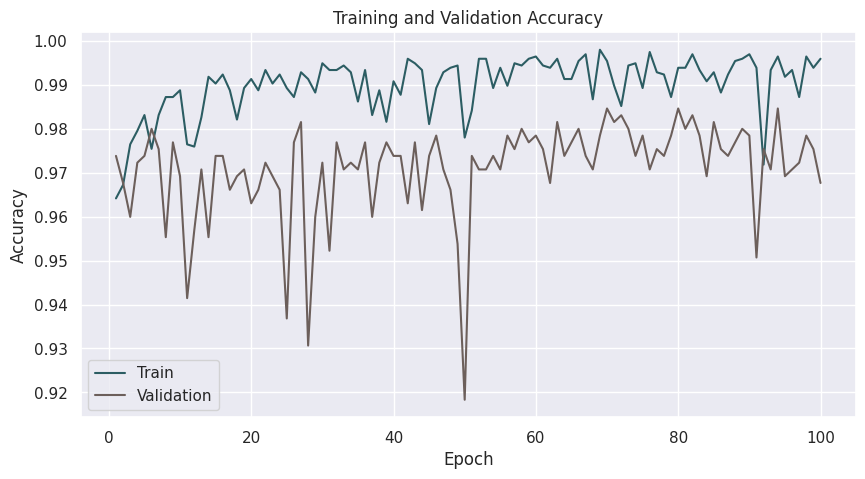

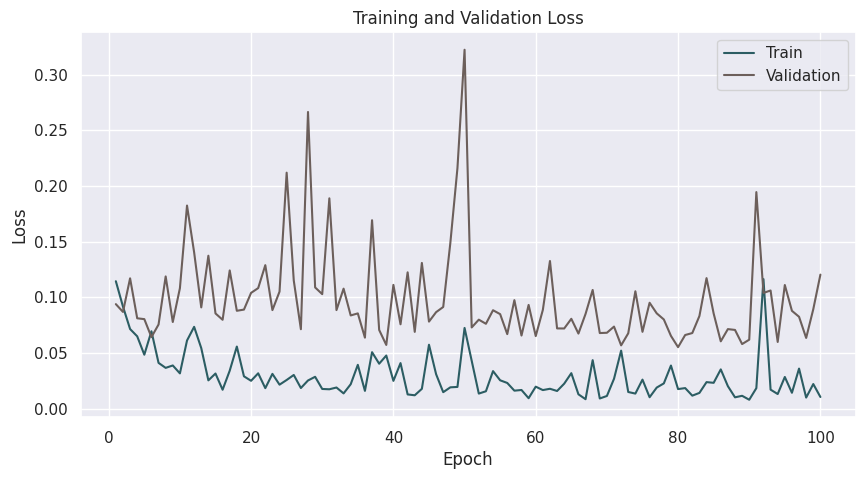

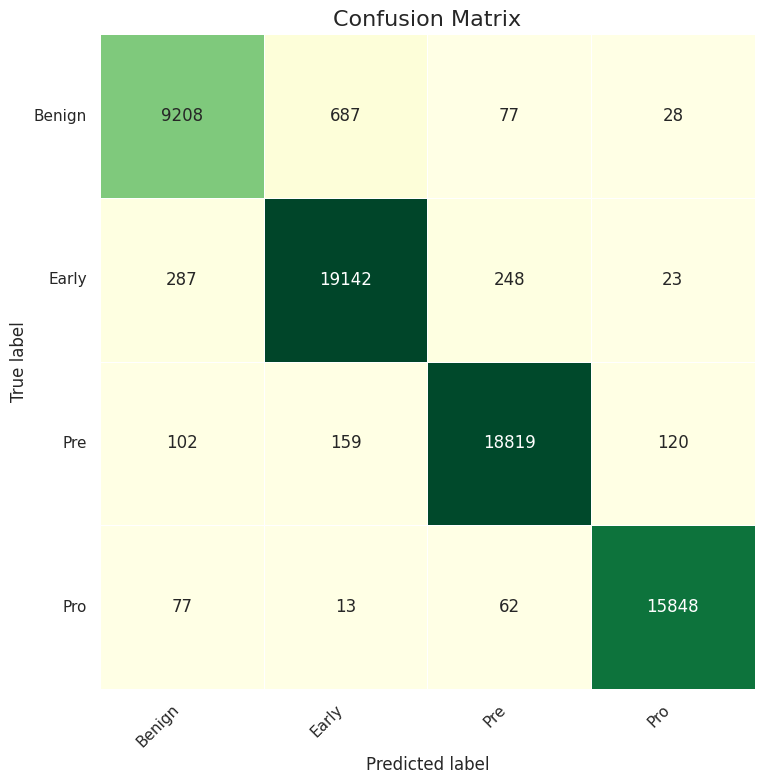

In [54]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler)

example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("/kaggle/working/kvasir_resnet152_E100_2class.pt")

In [55]:
import torch

model_path = "/kaggle/working/kvasir_resnet152_E100_2class.pt"
model = torch.jit.load(model_path)
model = model.to(device)


test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len

print('Test Loss: {:.{}f}'.format(test_loss, max(15, -int(np.log10(test_loss)) + 3)))

for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print('\nTest Accuracy : {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

100%|██████████| 21/21 [00:04<00:00,  4.42it/s]

Test Loss: 0.000000953383750
Test Accuracy of Benign: 95% (97/102)
Test Accuracy of Early: 97% (192/197)
Test Accuracy of   Pre: 100% (194/194)
Test Accuracy of   Pro: 98% (145/147)

Test Accuracy : 98.1250 (628/640)
